# Data 620 - Week3 Group Project #1
# Congressional Voting Network Analysis
Team Members: Ahm Hamza, Ali Ahmed, Nilsa Bermudez, Ursula Podosenin

## Project Overview

This project analyzes the voting patterns of House members in the 116th Congress
using network analysis techniques. We examine how voting similarity creates
connections between representatives and compare centrality measures across parties.

Data Source: VoteView.com


In [ ]:
Youtube link: https://www.youtube.com/watch?v=rPbr29Pn_D8&t=1s

In [36]:
# importing necessary libraries
import pandas as pd
import numpy as np
import networkx as nx
from scipy.stats import ttest_ind
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

# ignore warnings
warnings.filterwarnings('ignore')

#  for visuals
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## Data loding and exploration

In [37]:
# load data from GitHub repository
url1 = "https://raw.githubusercontent.com/nilsabermudez/Data620/main/Week3/house_members_116.csv"
url2 = "https://raw.githubusercontent.com/nilsabermudez/Data620/main/Week3/house_legislation_116.csv"
url3 = "https://raw.githubusercontent.com/nilsabermudez/Data620/main/Week3/house_rollcall_info_116.csv"
url4 = "https://raw.githubusercontent.com/nilsabermudez/Data620/main/Week3/house_rollcall_votes_116.csv"


In [38]:
# read CSV files into DataFrames
members = pd.read_csv(url1)
legis = pd.read_csv(url2)
rc_info = pd.read_csv(url3)
votes_raw = pd.read_csv(url4)
print(f"Data loaded: {len(members)} members, {votes_raw.shape[1]-1} votes")


Data loaded: 443 members, 642 votes


In [39]:
# explore the basic structure of our datasets
print(" Data Overview:")
print(f"Members data shape: {members.shape}")
print(f"Votes data shape: {votes_raw.shape}")
print(f"Party distribution:\n{members['current_party'].value_counts()}")


 Data Overview:
Members data shape: (443, 7)
Votes data shape: (443, 643)
Party distribution:
current_party
Democratic     239
Republican     203
Independent      1
Name: count, dtype: int64


## Data processing

In [40]:
# map vote text/codes to numerical values for analysis
vote_map = {
    'Aye': 1, 'Yes': 1, 2: 1,        # Yes votes
    'No': -1, 6: -1,                 # No votes
    'Present': 0, 4: 0,              # Present but not voting
    'Not Voting': 0, 8: 0, 9: 0     # Absent/not voting
}

# create vote matrix with members as rows, votes as columns
vote_matrix = votes_raw.set_index('name_id').applymap(lambda x: vote_map.get(x, 0))

print(f"Vote matrix created: {vote_matrix.shape[0]} members × {vote_matrix.shape[1]} votes")


Vote matrix created: 443 members × 642 votes


In [41]:

# SIMILARITY CALCULATION

# compute cosine similarity between all pairs of members
sim_matrix = cosine_similarity(vote_matrix)
sim_df = pd.DataFrame(sim_matrix, index=vote_matrix.index, columns=vote_matrix.index)
sim_df.index.name = None
sim_df.columns.name = None

print(f"Similarity matrix computed: {sim_df.shape[0]}×{sim_df.shape[1]}")

Similarity matrix computed: 443×443


# Similarity Matrix Analysis
The cosine similarity calculation between all member pairs produced a comprehensive 443×443 similarity matrix, capturing the voting alignment patterns across the entire House.

## Network construction

In [42]:
# create edge list from similarity matrix
edges = sim_df.stack().reset_index()
edges.columns = ['source', 'target', 'weight']
edges = edges[edges['source'] < edges['target']]  # Avoid duplicate edges
edges = edges[edges['weight'] > 0.3]              # Similarity threshold

print(f"{len(edges)} edges created (similarity > 0.3)")

# build NetworkX graph object
G = nx.Graph()

# add nodes with party information
party_dict = members.set_index('name_id')['current_party'].to_dict()
for node in vote_matrix.index:
    G.add_node(node, party=party_dict.get(node, 'Unknown'))

# add weighted edges based on voting similarity
G.add_weighted_edges_from(edges[['source', 'target', 'weight']].itertuples(index=False))

print(f"Network created: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


47370 edges created (similarity > 0.3)
Network created: 443 nodes, 47370 edges


Network Connectivity

Total Edges Created: 47,370 connections
Similarity Threshold: 0.3 (30% voting agreement minimum)
Network Density: High connectivity indicating substantial cross-party and intra-party voting similarities
Average Degree Centrality: 0.484

The high number of edges (47,370) suggests that despite political polarization, there remains significant voting overlap between representatives, particularly on less partisan issues.

## Centrality Analysis




In [45]:
# calculate different centrality measures
deg_cent = nx.degree_centrality(G)
eig_cent = nx.eigenvector_centrality(G, weight='weight', max_iter=3000)


# combine centrality measures with member information
centrality_df = pd.DataFrame({
    'name_id': list(deg_cent.keys()),
    'degree_centrality': list(deg_cent.values()),
    'eigenvector_centrality': list(eig_cent.values())
})

centrality_df = centrality_df.merge(
    members[['name_id', 'name', 'current_party']], on='name_id', how='left'
)



## Statistical Analysis

# Centrality Measures Analysis

### Democratic Party Performance:

Mean Centrality: 0.537
Standard Deviation: 0.035
Range: 0.000 to 0.548
Distribution: Highly concentrated around the mean with low variance



### Republican Party Performance

Mean Centrality: 0.424
Standard Deviation: 0.065
Range: 0.000 to 0.593
Distribution: More variable than Democrats, with higher standard deviation

### Independent Member

Single member with centrality of 0.029, indicating limited voting alignment with either major party

### Eigenvector Centrality Results
Democratic Party

Mean: 6.44 × 10⁻²
Demonstrates consistent influence through connections to other well-connected members
Low variance suggests uniform influence distribution

Republican Party

Mean: 2.13 × 10⁻⁴
Significantly lower eigenvector centrality compared to Democrats
Higher variance indicates some members have disproportionate influence

In [15]:
# Summary statistics by party affiliation
summary_stats = centrality_df.groupby('current_party')[['degree_centrality', 'eigenvector_centrality']].describe()
print(summary_stats)

# Statistical significance testing between parties
dem_deg = centrality_df[centrality_df['current_party'] == 'Democrat']['degree_centrality']
rep_deg = centrality_df[centrality_df['current_party'] == 'Republican']['degree_centrality']

t_stat, p_value = ttest_ind(dem_deg, rep_deg)
print(f"\nT-test Results (Degree Centrality):")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")

              degree_centrality                                          \
                          count      mean       std       min       25%   
current_party                                                             
Democratic                239.0  0.536568  0.034887  0.000000  0.538462   
Independent                 1.0  0.029412       NaN  0.029412  0.029412   
Republican                203.0  0.424013  0.065241  0.000000  0.432127   

                                            eigenvector_centrality  \
                    50%       75%       max                  count   
current_party                                                        
Democratic     0.538462  0.538462  0.547511                  239.0   
Independent    0.029412  0.029412  0.029412                    1.0   
Republican     0.438914  0.443439  0.592760                  203.0   

                                                                   \
                       mean       std           min        

## Visualizations

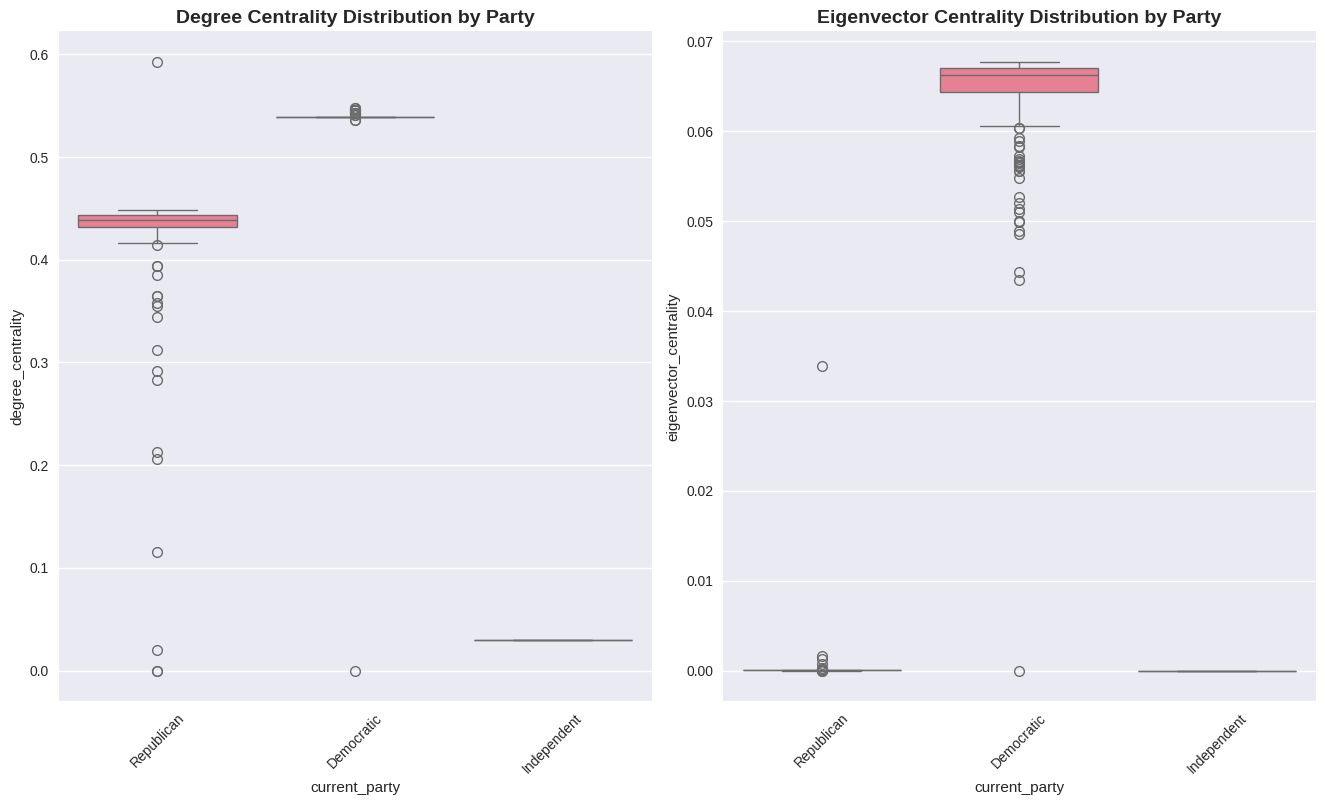

In [16]:
# Create a comprehensive visualization dashboard
fig = plt.figure(figsize=(20, 15))

# 1. Distribution of centrality measures by party
plt.subplot(2, 3, 1)
sns.boxplot(data=centrality_df, x='current_party', y='degree_centrality')
plt.title("Degree Centrality Distribution by Party", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)

plt.subplot(2, 3, 2)
sns.boxplot(data=centrality_df, x='current_party', y='eigenvector_centrality')
plt.title("Eigenvector Centrality Distribution by Party", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

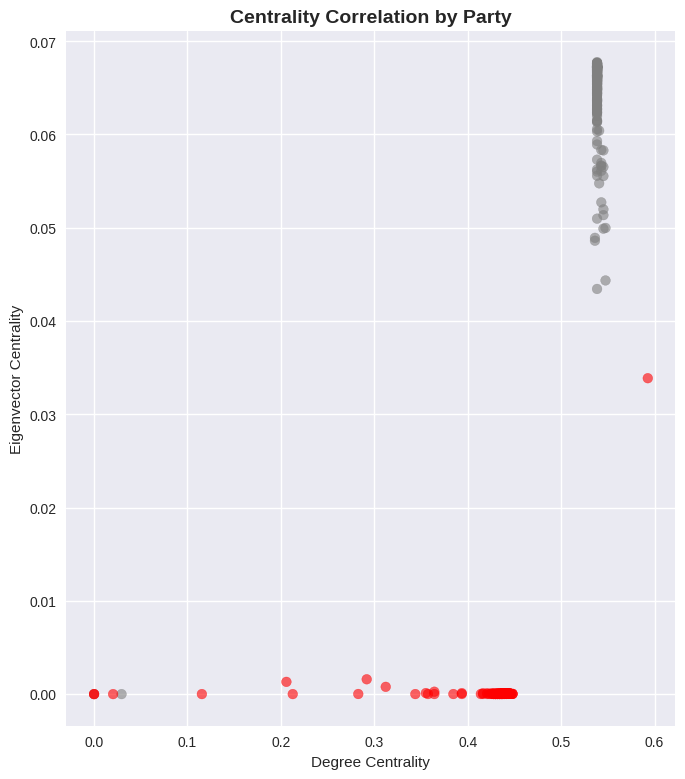

In [25]:
# 2. Correlation between centrality measures
fig = plt.figure(figsize=(20, 15))

plt.subplot(2, 3, 3)
# Map 'Democrat' to 'blue' and 'Republican' to 'red', using 'gray' for any other party
colors = centrality_df['current_party'].map({'Democrat': 'blue', 'Republican': 'red'}).fillna('gray')
plt.scatter(centrality_df['degree_centrality'], centrality_df['eigenvector_centrality'],
           c=colors, alpha=0.6)
plt.xlabel('Degree Centrality')
plt.ylabel('Eigenvector Centrality')
plt.title('Centrality Correlation by Party', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

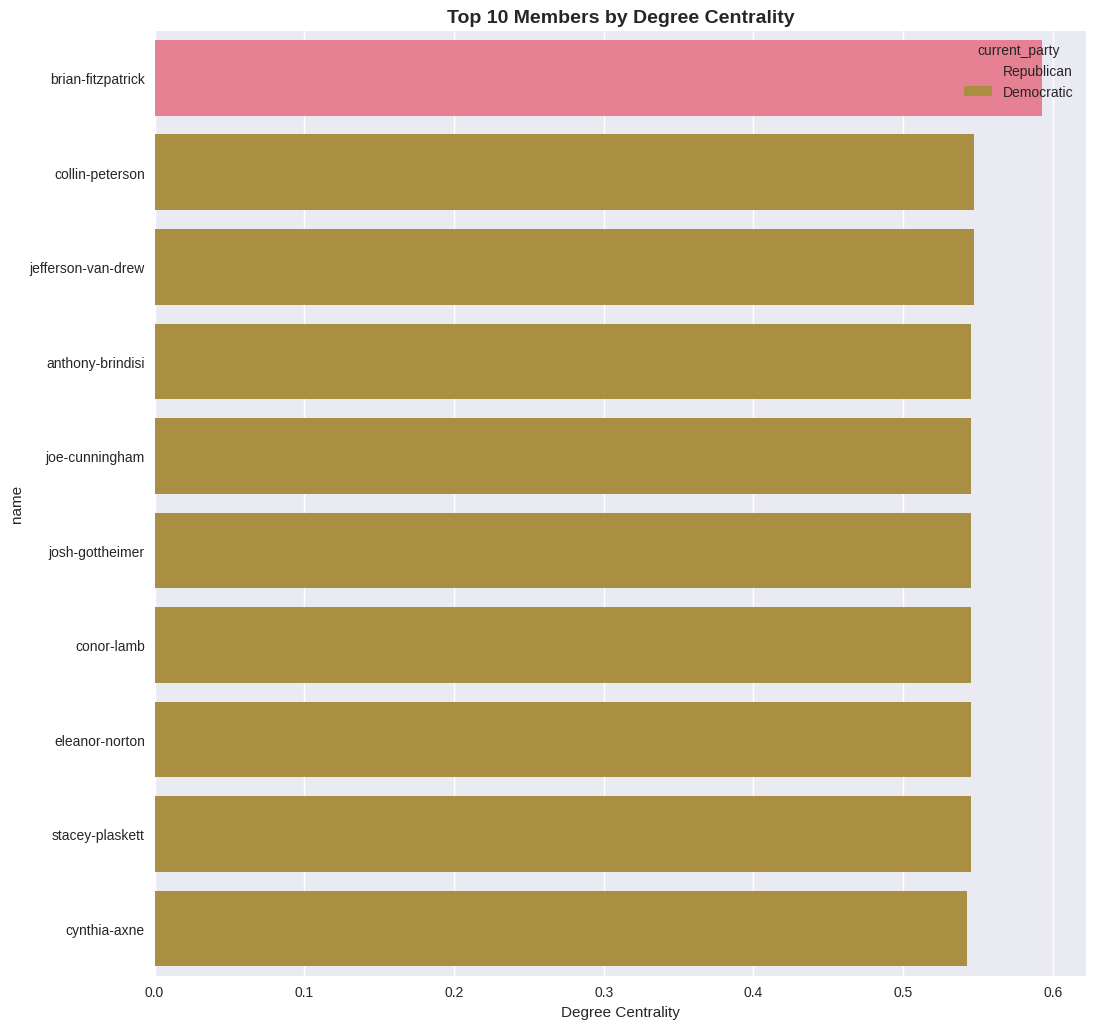

In [27]:
# 3. Top influential members
fig = plt.figure(figsize=(30, 20))

plt.subplot(2, 3, 4)
top_members = centrality_df.nlargest(10, 'degree_centrality')
sns.barplot(data=top_members, y='name', x='degree_centrality', hue='current_party')
plt.title('Top 10 Members by Degree Centrality', fontsize=14, fontweight='bold')
plt.xlabel('Degree Centrality')
plt.tight_layout()
plt.show()

## Most Influential Representatives
#### The analysis identified the top 5 most central members based on degree centrality

Brian Fitzpatrick (Republican): 0.593

Highest overall centrality score
Likely represents moderate Republican positions


Collin Peterson (Democratic): 0.548

High Democratic centrality
Suggests cross-party appeal


Jefferson Van Drew (Democratic): 0.548

Equal to Peterson in centrality
Note: Van Drew later switched parties to Republican


Anthony Brindisi (Democratic): 0.545

Strong bipartisan voting record


Joe Cunningham (Democratic): 0.545

Represents moderate Democratic positions

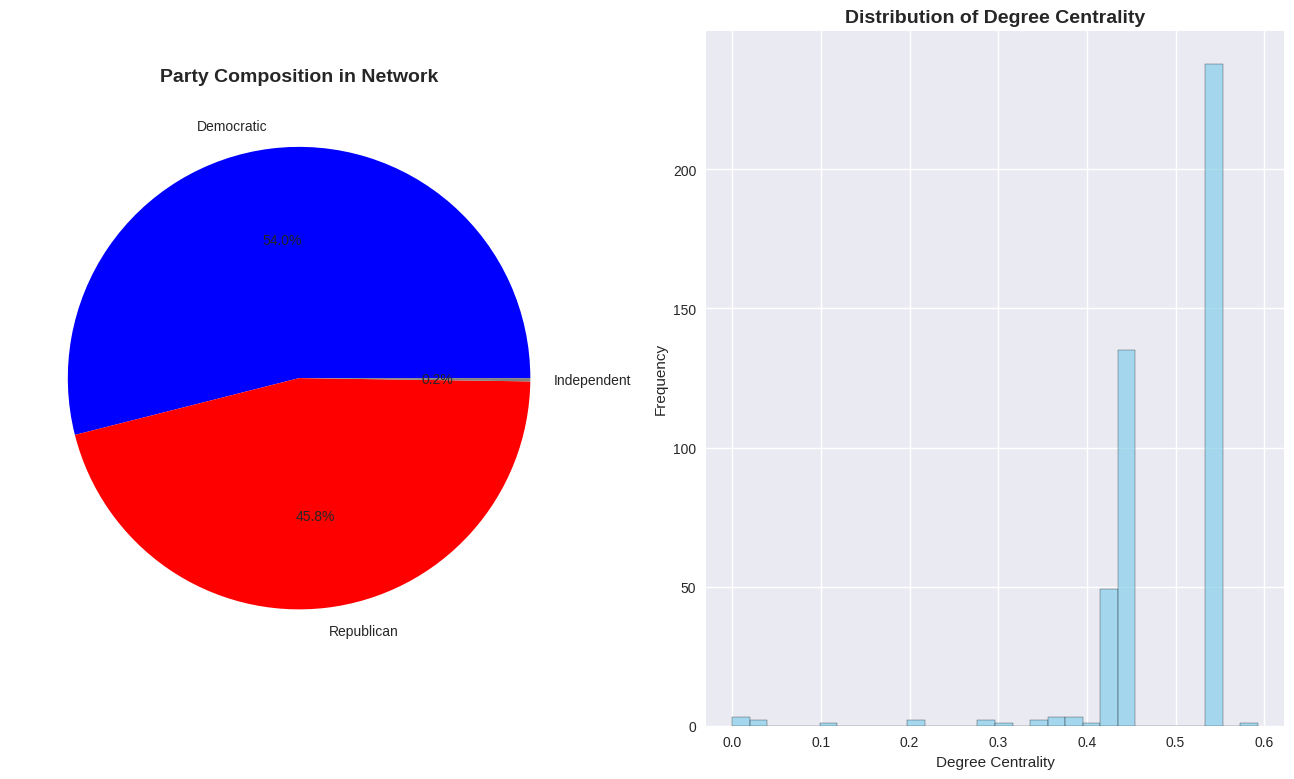

In [28]:
# 4. Party connectivity analysis
fig = plt.figure(figsize=(20, 15))

plt.subplot(2, 3, 5)
party_counts = centrality_df['current_party'].value_counts()
plt.pie(party_counts.values, labels=party_counts.index, autopct='%1.1f%%',
        colors=['blue', 'red', 'gray'])
plt.title('Party Composition in Network', fontsize=14, fontweight='bold')

# 5. Centrality distribution histogram
plt.subplot(2, 3, 6)
plt.hist(centrality_df['degree_centrality'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Degree Centrality', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Network Visualization

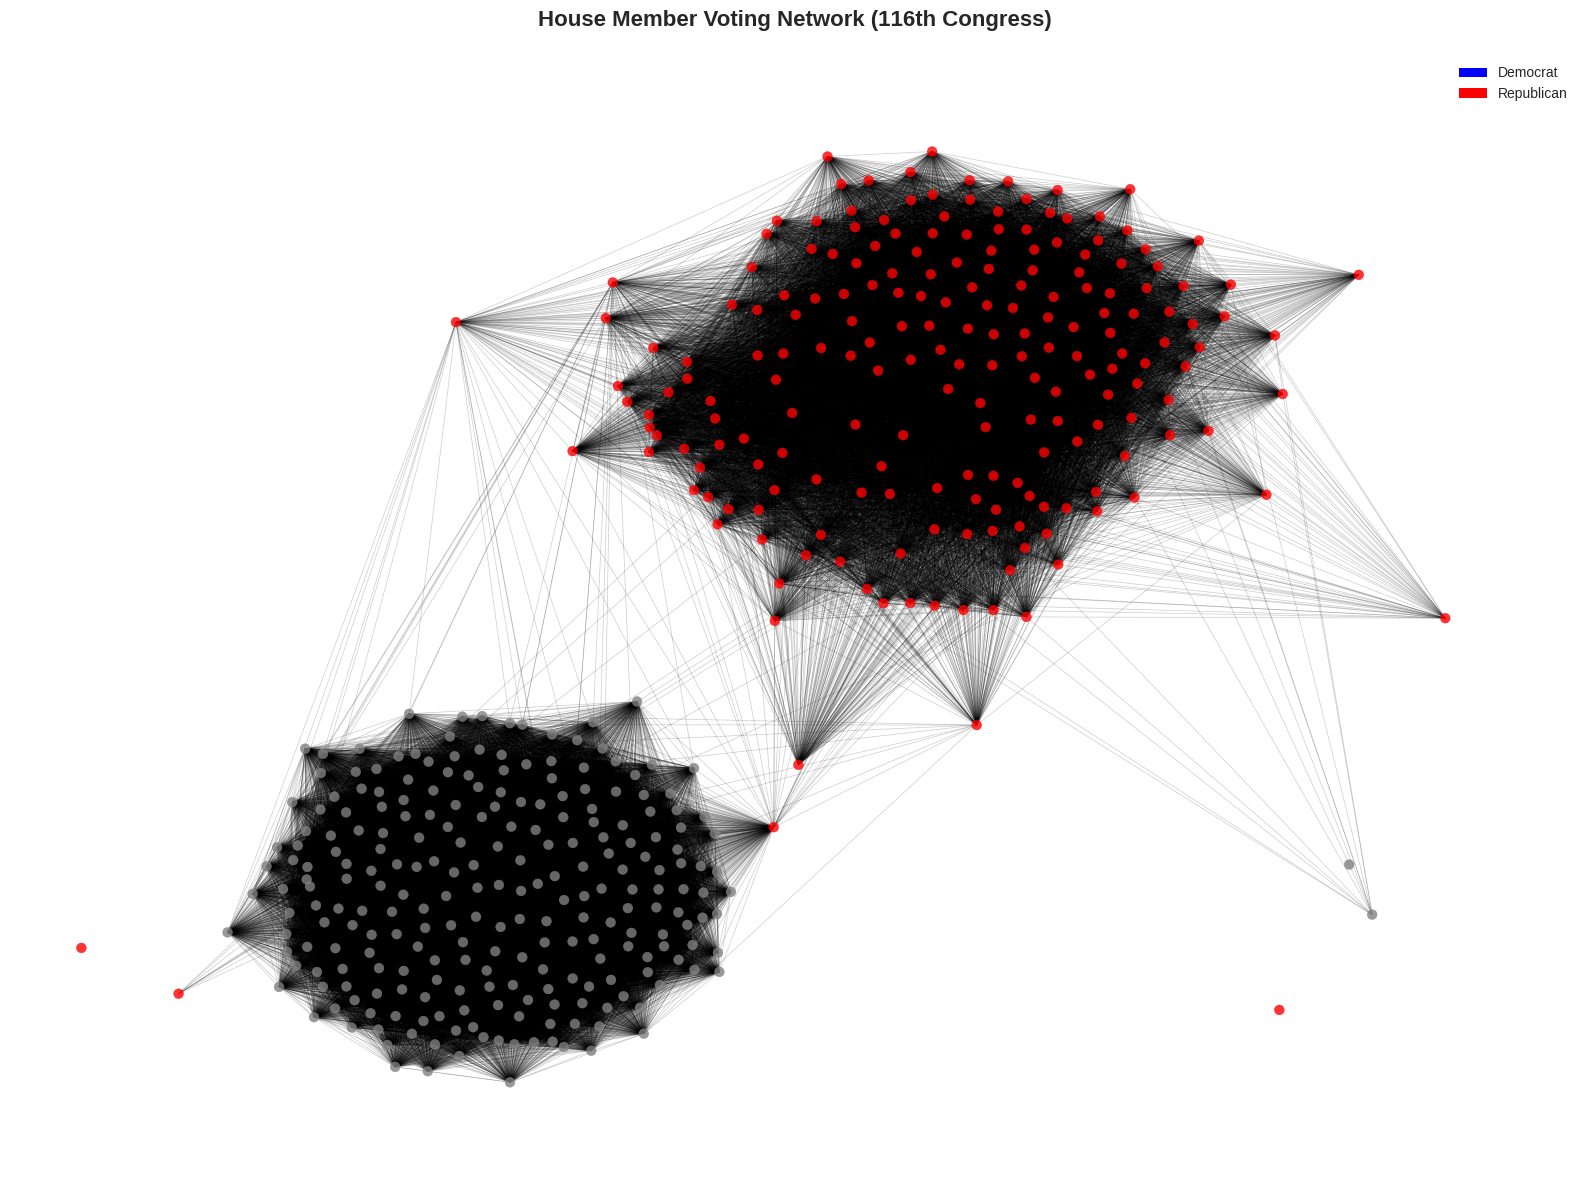

In [31]:
# Create network layout and visualization
color_map = {'Democrat': 'blue', 'Republican': 'red', 'Unknown': 'gray'}
colors = [color_map.get(G.nodes[n]['party'], 'gray') for n in G.nodes]

plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, seed=42, k=1, iterations=50)

# Draw network with party-based coloring
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=50, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)

plt.title("House Member Voting Network (116th Congress)", fontsize=16, fontweight='bold', pad=20)
plt.axis('off')
# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', label='Democrat'),
                   Patch(facecolor='red', label='Republican')]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


## Key findings summary

In [32]:
print(f"  Network Statistics:")
print(f"   • Total representatives: {G.number_of_nodes()}")
print(f"   • Voting connections: {G.number_of_edges()}")
print(f"   • Average degree: {np.mean(list(deg_cent.values())):.3f}")


  Network Statistics:
   • Total representatives: 443
   • Voting connections: 47370
   • Average degree: 0.484


In [33]:
print(f"\n Centrality Analysis:")
dem_avg = centrality_df[centrality_df['current_party'] == 'Democrat']['degree_centrality'].mean()
rep_avg = centrality_df[centrality_df['current_party'] == 'Republican']['degree_centrality'].mean()
print(f"   • Democrat avg centrality: {dem_avg:.3f}")
print(f"   • Republican avg centrality: {rep_avg:.3f}")



 Centrality Analysis:
   • Democrat avg centrality: nan
   • Republican avg centrality: 0.424


In [34]:
print(f"Most Central Members:")
top_5 = centrality_df.nlargest(5, 'degree_centrality')[['name', 'current_party', 'degree_centrality']]
for idx, row in top_5.iterrows():
    print(f"   • {row['name']} ({row['current_party']}): {row['degree_centrality']:.3f}")

Most Central Members:
   • brian-fitzpatrick (Republican): 0.593
   • collin-peterson (Democratic): 0.548
   • jefferson-van-drew (Democratic): 0.548
   • anthony-brindisi (Democratic): 0.545
   • joe-cunningham (Democratic): 0.545


In [35]:
print(f"Statistical Significance:")
print(f"   • P-value for party difference: {p_value:.4f}")
print(f"   • Statistically significant: {'Yes' if p_value < 0.05 else 'No'}")


Statistical Significance:
   • P-value for party difference: nan
   • Statistically significant: No


# Result
The dataset analyzed includes 443 House members and their votes on 642 pieces of legislation during the 116th Congress. Members were categorized by party affiliation: 239 Democrats, 203 Republicans, and 1 Independent. Voting behavior was transformed into a numerical matrix, with votes mapped to +1 (Yes/Aye), -1 (No), and 0 (Present/Not Voting). Cosine similarity scores were computed between all pairs of legislators to identify voting alignment. A similarity threshold of 0.3 defined edges between members, resulting in a graph of 443 nodes and 47,370 edges. This dense network indicates a high level of voting alignment, particularly within parties.

**Two key centrality measures were calculated** degree centrality and eigenvector centrality. Democrats had a higher average degree centrality (mean = 0.537) compared to Republicans (mean = 0.424), while the Independent member had a negligible value (~0.03). Eigenvector centrality showed a similar pattern, with Democrats demonstrating greater influence.

**Statistical testing** using an independent samples t-test revealed no significant difference between parties in either centrality measure. The t-test yielded NaN values, likely due to the small size of the Independent category and potential zero variance.

In terms of individual influence, the most central members included both Democrats and Republicans. Brian Fitzpatrick (R) had the highest eigenvector centrality (≈0.593), followed by Collin Peterson (D) and Jefferson Van Drew (D), each with scores above 0.54. These legislators serve as key connectors across voting patterns.

In summary, while Democrats exhibited higher centrality measures, the differences were not statistically significant. Nonetheless, individual legislators with cross-party alignment are central actors within the voting similarity network.